In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import shap 

# Import datasets

In [2]:
csv_path = os.path.join("..", "..", "data","LINKED_DATA", "TSR_ALL", "TSR_ALL1", "TSR_ALL1_MICE2.csv")
tsr_all1_df = pd.read_csv(csv_path)
tsr_all1_df.shape

(44367, 233)

In [3]:
csv_path = os.path.join("..", "..", "data","LINKED_DATA", "TSR_ALL", "TSR_ALL3", "TSR_ALL3_MICE5.csv")
tsr_all3_df = pd.read_csv(csv_path)
tsr_all3_df.shape

(39881, 234)

In [4]:
csv_path = os.path.join("..", "..", "result", "TSR_ALL", "INFO", "Threshold_Intersection.csv")
T_I = pd.read_csv(csv_path, keep_default_na = False)

# Convert the multiple feature and outcome into binary ones

In [5]:
mRS1 = tsr_all1_df.mrs_tx_1
mRS1[(mRS1 == 0) | (mRS1 == 1) | (mRS1 == 2)] = 1 #GOOD
mRS1[(mRS1 == 3) | (mRS1 == 4) | (mRS1 == 5) | (mRS1 == 6) | (mRS1 == 9)] = 0 #BAD
mRS3 = tsr_all3_df.mrs_tx_3
mRS3[(mRS3 == 0) | (mRS3 == 1) | (mRS3 == 2)] = 1 #GOOD
mRS3[(mRS3 == 3) | (mRS3 == 4) | (mRS3 == 5) | (mRS3 == 6) | (mRS3 == 9)] = 0 #BAD

# Group all features and the outcome

In [6]:
nominal_features = ["edu_id", "pro_id", "opc_id", "toast_id", "offdt_id", "gender_tx", "hd_id", "pcva_id",
                    "pcvaci_id", "pcvach_id", "po_id", "ur_id", "sm_id", "ptia_id", "hc_id", "hcht_id",
                    "hchc_id", "ht_id", "dm_id", "pad_id", "al_id", "ca_id", "fahiid_parents_1",
                    "fahiid_parents_2", "fahiid_parents_3", "fahiid_parents_4", "fahiid_brsi_1",
                    "fahiid_brsi_2", "fahiid_brsi_3", "fahiid_brsi_4"]
ordinal_features = ["gcse_nm", "gcsv_nm", "gcsm_nm", "discharged_mrs", "feeding", "transfers",
                    "bathing", "toilet_use", "grooming", "mobility", "stairs", "dressing", "bowel_control",
                    "bladder_control", "nihs_1a_in", "nihs_1b_in", "nihs_1c_in", "nihs_2_in", "nihs_3_in", "nihs_4_in",
                    "nihs_5al_in", "nihs_5br_in", "nihs_6al_in", "nihs_6br_in", "nihs_7_in", "nihs_8_in", "nihs_9_in",
                    "nihs_10_in", "nihs_11_in", "nihs_1a_out", "nihs_1b_out", "nihs_1c_out", "nihs_2_out", "nihs_3_out",
                    "nihs_4_out", "nihs_5al_out", "nihs_5br_out", "nihs_6al_out", "nihs_6br_out", "nihs_7_out",
                    "nihs_8_out", "nihs_9_out", "nihs_10_out", "nihs_11_out"]
boolean = ["toastle_fl", "toastli_fl", "toastsce_fl", "toastsmo_fl", "toastsra_fl", "toastsdi_fl",
           "toastsmi_fl", "toastsantip_fl", "toastsau_fl", "toastshy_fl", "toastspr_fl", "toastsantit_fl",
           "toastsho_fl", "toastshys_fl", "toastsca_fl", "thda_fl", "thdh_fl", "thdi_fl", "thdam_fl", "thdv_fl",
           "thde_fl", "thdm_fl", "thdr_fl", "thdp_fl", "trman_fl", "trmas_fl", "trmti_fl", "trmhe_fl",
           "trmwa_fl", "trmia_fl", "trmfo_fl", "trmta_fl", "trmsd_fl", "trmre_fl", "trmen_fl", "trmag_fl",
           "trmcl_fl", "trmpl_fl", "trmlm_fl", "trmiv_fl", "trmve_fl", "trmng_fl", "trmdy_fl", "trmicu_fl",
           "trmsm_fl", "trmed_fl", "trmop_fl", "om_fl", "omas_fl", "omag_fl", "omti_fl", "omcl_fl", "omwa_fl",
           "ompl_fl", "omanh_fl", "omand_fl", "omli_fl", "am_fl", "amas_fl", "amag_fl", "amti_fl", "amcl_fl",
           "amwa_fl", "ampl_fl", "amanh_fl", "amand_fl", "amli_fl", "compn_fl", "comut_fl", "comug_fl",
           "compr_fl", "compu_fl", "comac_fl", "comse_fl", "comde_fl", "detst_fl", "dethe_fl", "detho_fl",
           "detha_fl", "detva_fl", "detre_fl", "detme_fl", "ct_fl", "mri_fl", "ecgl_fl", "ecga_fl", "ecgq_fl",
           "cortical_aca_ctr", "cortical_mca_ctr", "subcortical_aca_ctr", "subcortical_mca_ctr", "pca_cortex_ctr",
           "thalamus_ctr", "brainstem_ctr", "cerebellum_ctr", "watershed_ctr", "hemorrhagic_infarct_ctr",
           "old_stroke_ctci", "cortical_aca_ctl", "cortical_mca_ctl", "subcortical_aca_ctl", "subcortical_mca_ctl",
           "pca_cortex_ctl", "thalamus_ctl", "brainstem_ctl", "cerebellum_ctl", "watershed_ctl",
           "hemorrhagic_infarct_ctl", "old_stroke_ctch", "cortical_aca_mrir", "cortical_mca_mrir",
           "subcortical_aca_mrir", "subcortical_mca_mrir", "pca_cortex_mrir", "thalamus_mrir", "brainstem_mrir",
           "cerebellum_mrir", "watershed_mrir", "hemorrhagic_infarct_mrir", "old_stroke_mrici", "cortical_aca_mril",
           "cortical_mca_mril", "subcortical_aca_mril", "subcortical_mca_mril", "pca_cortex_mril",
           "thalamus_mril", "brainstem_mril", "cerebellum_mril", "watershed_mril", "hemorrhagic_infarct_mril",
           "old_stroke_mrich"]
continuous = ["height_nm", "weight_nm", "sbp_nm", "dbp_nm", "bt_nm", "hr_nm", "rr_nm", "hb_nm",
              "hct_nm", "platelet_nm", "wbc_nm", "ptt1_nm", "ptt2_nm", "ptinr_nm", "er_nm", "bun_nm",
              "cre_nm", "ua_nm", "tcho_nm", "tg_nm", "hdl_nm",
              "ldl_nm", "gpt_nm", "age", "hospitalised_time"]
labels = ["mrs_tx_1"]

# Machine Learning - TSR_ALL1

## Preprocess input data (GOOD when Discharge)

In [7]:
## discharged mRS = GOOD (tsr_all1_df.discharged_mrs == 1)
mrs_dis1 = tsr_all1_df[(tsr_all1_df.discharged_mrs == 1) | (tsr_all1_df.discharged_mrs == 0) | (tsr_all1_df.discharged_mrs == 2)]

In [8]:
## input dataset
tsr_1G_input = mrs_dis1.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1)
print(tsr_1G_input.shape)
tsr_1G_input = tsr_1G_input.astype("float64")
tsr_1G_input = np.array(tsr_1G_input.values)

(20658, 230)


In [9]:
## output dataset
tsr_1G_output = mrs_dis1.mrs_tx_1
print(tsr_1G_output.shape)
tsr_1G_output = tsr_1G_output.astype("float64")
tsr_1G_output = np.array(tsr_1G_output.values)

(20658,)


In [10]:
## train_test_split
G_X_train, G_X_test, G_y_train, G_y_test = train_test_split(tsr_1G_input, tsr_1G_output, test_size=0.3, random_state=19)
print("The shape of GOOD's X_train:", G_X_train.shape)
print("The shape of GOOD's y_train:", G_y_train.shape)
print("The shape of GOOD's X_test:", G_X_test.shape)
print("The shape of GOOD's y_test:", G_y_test.shape)

The shape of GOOD's X_train: (14460, 230)
The shape of GOOD's y_train: (14460,)
The shape of GOOD's X_test: (6198, 230)
The shape of GOOD's y_test: (6198,)


In [11]:
## scale G_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
G_X_train = pd.DataFrame(G_X_train)
G_X_train.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

scaler = MinMaxScaler()
G_X_train[continuous] = scaler.fit_transform(G_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=6)
G_X_train[ordinal_features] = encoder.fit_transform(G_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
nominal_train = ohe.fit_transform(G_X_train[nominal_features])
G_X_train = pd.concat([G_X_train, pd.DataFrame(nominal_train)], axis=1)
G_X_train = G_X_train.drop(nominal_features, axis=1)

G_x_train_columns = list(G_X_train.columns)
G_x_train_columns = G_x_train_columns[0:200]
get_feature_name = list(ohe.get_feature_names(nominal_features))
G_x_train_columns = G_x_train_columns+get_feature_name

G_X_train.columns = G_x_train_columns
G_X_train_overlap = G_X_train[T_I["G1"][0:13]]

#G_X_train_overlap = np.array(G_X_train_overlap.values)

In [12]:
## scale G_X_test
G_X_test = pd.DataFrame(G_X_test)
G_X_test.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

G_X_test[continuous] = scaler.transform(G_X_test[continuous])

G_X_test[ordinal_features] = encoder.transform(G_X_test[ordinal_features])

nominal_test = ohe.transform(G_X_test[nominal_features])
G_X_test = pd.concat([G_X_test, pd.DataFrame(nominal_test)], axis=1)
G_X_test = G_X_test.drop(nominal_features, axis=1)

G_X_test.columns = G_x_train_columns
G_X_test_overlap = G_X_test[T_I["G1"][0:13]]

#G_X_test_overlap = np.array(G_X_test_overlap.values)

## Algorithms

## Extra trees

In [13]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 32}, {0: 32, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [14]:
#based
et.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = et.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et)

G_y_test_pred = et.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et)

#tuned
etG_rsCV = etG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Parameters Best Score: ', etG_rsCV.best_score_)
print('--> Best Parameters: \n', etG_rsCV.best_params_)

G_y_train_pred = etG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et_tuned)

G_y_test_pred = etG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et_tuned)

#calibrated
etG_cccv = CalibratedClassifierCV(base_estimator=etG_rsCV.best_estimator_, cv=5)
etG_ccCV = etG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = etG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et_cc)

G_y_test_pred = etG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et_cc)

AUC of training set: 0.86608693987686
AUC of testing set: 0.5149215990295452
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7076162143070039
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 32, 1: 1}, 'extratreesclassifier__bootstrap': True}
AUC of training set: 0.7630329618540697
AUC of testing set: 0.6764989300221684
AUC of training set: 0.7566804222243344
AUC of testing set: 0.6806387404588303


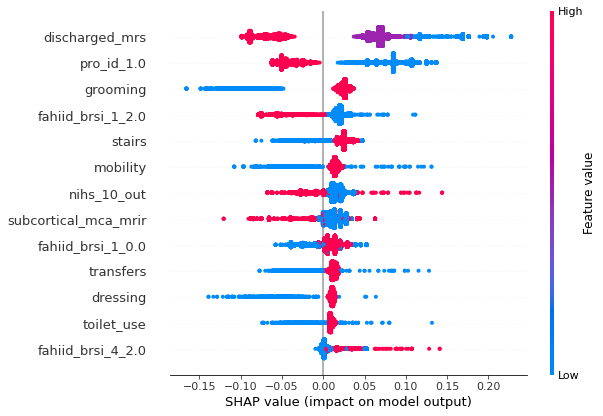

In [16]:
etG1_shap_values = shap.TreeExplainer(etG_ccCV.base_estimator._final_estimator).shap_values(G_X_train_overlap)

shap.summary_plot(etG1_shap_values[1], G_X_train_overlap)

## XGBClassifier

In [17]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.03, 32)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcG_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

In [18]:
#based
xgbc.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = xgbc.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc)

G_y_test_pred = xgbc.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc)

#tuned
xgbcG_rsCV = xgbcG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Paramxgbcers Best Score: ', xgbcG_rsCV.best_score_)
print('--> Best Paramxgbcers: \n', xgbcG_rsCV.best_params_)

G_y_train_pred = xgbcG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc_tuned)

G_y_test_pred = xgbcG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc_tuned)

#calibrated
xgbcG_cccv = CalibratedClassifierCV(base_estimator=xgbcG_rsCV.best_estimator_, cv=5)
xgbcG_ccCV = xgbcG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = xgbcG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc_cc)

G_y_test_pred = xgbcG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc_cc)

AUC of training sxgbc: 0.8226655980367307
AUC of testing sxgbc: 0.5937565405331522
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.7212933731760965
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 0.03, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 50, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3}
AUC of training sxgbc: 0.7336434109294638
AUC of testing sxgbc: 0.7031958379784466
AUC of training sxgbc: 0.7337287231093369
AUC of testing sxgbc: 0.7011276413075513


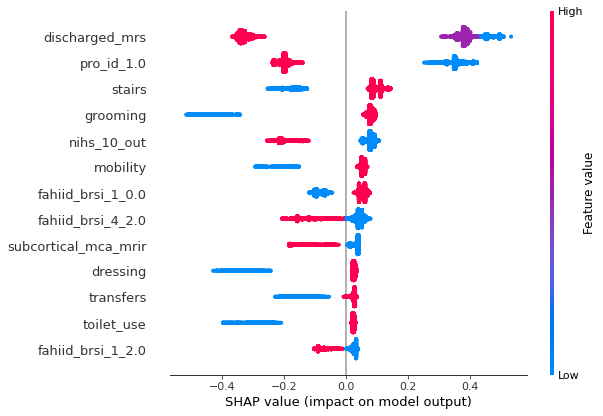

In [19]:
xgbcG1_shap_values = shap.TreeExplainer(xgbcG_ccCV.base_estimator._final_estimator).shap_values(G_X_train_overlap)

shap.summary_plot(xgbcG1_shap_values, G_X_train_overlap)

## LogisticRegression

In [20]:
# base lr
lr = LogisticRegression(random_state=19)

#tune lr
hyperparameters_lr = {"logisticregression__penalty": ("l1", "l2", "elasticnet", "none"),
                      "logisticregression__tol": (1e-4, 1e-3, 1e-2, 1e-1),
                      "logisticregression__C": (0.1, 1, 10),
                      "logisticregression__solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
                      "logisticregression__multi_class": ("auto", "ovr", "multinomial"),
                      "logisticregression__warm_start": (True, False),
                      "logisticregression__class_weight": ('balanced', {0: 1, 1: 32}, {0: 32, 1: 1})}

pipeline = make_pipeline(TomekLinks(), LogisticRegression(random_state=19))

lrG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_lr,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [21]:
lr.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = lr.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr)

G_y_test_pred = lr.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr)

#tuned
lrG_rsCV = lrG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Parameters Best Score: ', lrG_rsCV.best_score_)
print('--> Best Parameters: \n', lrG_rsCV.best_params_)

G_y_train_pred = lrG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr_tuned)

G_y_test_pred = lrG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr_tuned)

#calibrated
lrG_cccv = CalibratedClassifierCV(base_estimator=lrG_rsCV.best_estimator_, cv=5)
lrG_ccCV = lrG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = lrG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr_cc)

G_y_test_pred = lrG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr_cc)

AUC of training set: 0.7266041660066112
AUC of testing set: 0.6960079789165247
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7196737577298448
--> Best Parameters: 
 {'logisticregression__warm_start': False, 'logisticregression__tol': 0.01, 'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'none', 'logisticregression__multi_class': 'ovr', 'logisticregression__class_weight': {0: 1, 1: 32}, 'logisticregression__C': 1}
AUC of training set: 0.7263191870227799
AUC of testing set: 0.6961173259524085
AUC of training set: 0.7264081295081795
AUC of testing set: 0.6959259686396118


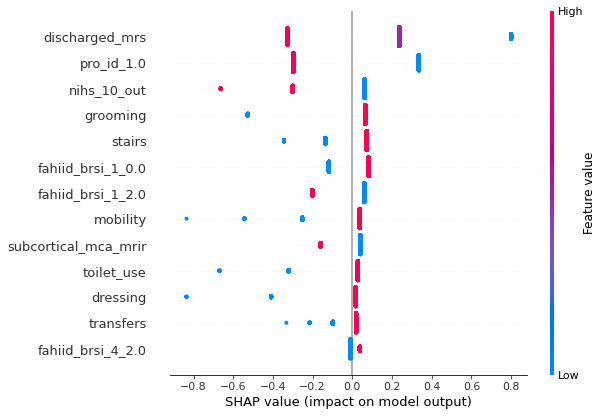

In [22]:
lrG1_explainer = shap.LinearExplainer(lrG_ccCV.base_estimator._final_estimator, G_X_train_overlap).shap_values(G_X_train_overlap)

shap.summary_plot(lrG1_explainer, G_X_train_overlap)

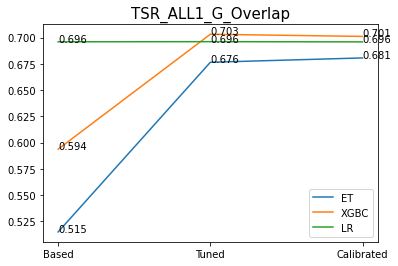

In [23]:
G_et_list = [G_test_auroc_et, G_test_auroc_et_tuned, G_test_auroc_et_cc]
G_xgbc_list = [G_test_auroc_xgbc, G_test_auroc_xgbc_tuned, G_test_auroc_xgbc_cc]
G_lr_list = [G_test_auroc_lr, G_test_auroc_lr_tuned, G_test_auroc_lr_cc]
x = "Based","Tuned","Calibrated"

plt.plot(x, G_et_list, label = "ET")
plt.plot(x, G_xgbc_list, label = "XGBC")
plt.plot(x, G_lr_list, label = "LR")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_et_list[i],3), (x[i], G_et_list[i]))
    plt.annotate(round(G_xgbc_list[i],3), (x[i], G_xgbc_list[i]))
    plt.annotate(round(G_lr_list[i],3), (x[i], G_lr_list[i]))
plt.title('TSR_ALL1_G_Overlap', fontsize=15)
#plt.savefig('INFO/TSR_ALL1/TSR_ALL1_G_Overlap.png')
plt.show()

# Machine Learning - TSR_ALL1

## Preprocess input data (BAD when Discharge)

In [35]:
# discharged mRS = BAD (tsr_all1_df.discharged_mrs == 0)
mrs_dis0 = tsr_all1_df[(tsr_all1_df.discharged_mrs != 1) & (tsr_all1_df.discharged_mrs != 0) & (tsr_all1_df.discharged_mrs != 2)]

In [36]:
## input dataset
tsr_1B_input = mrs_dis0.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1)
print(tsr_1B_input.shape)
tsr_1B_input = tsr_1B_input.astype("float64")
tsr_1B_input = np.array(tsr_1B_input.values)

(23709, 230)


In [37]:
## output dataset
tsr_1B_output = mrs_dis0.mrs_tx_1
print(tsr_1B_output.shape)
tsr_1B_output = tsr_1B_output.astype("float64")
tsr_1B_output = np.array(tsr_1B_output.values)

(23709,)


In [38]:
## train_test_split
B_X_train, B_X_test, B_y_train, B_y_test = train_test_split(tsr_1B_input, tsr_1B_output, test_size=0.3, random_state=19)
print("The shape of X_train:", B_X_train.shape)
print("The shape of y_train:", B_y_train.shape)
print("The shape of X_test:", B_X_test.shape)
print("The shape of y_test:", B_y_test.shape)

The shape of X_train: (16596, 230)
The shape of y_train: (16596,)
The shape of X_test: (7113, 230)
The shape of y_test: (7113,)


In [39]:
## scale B_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

B_X_train = pd.DataFrame(B_X_train)
B_X_train.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

scaler = MinMaxScaler()
B_X_train[continuous] = scaler.fit_transform(B_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=9)
B_X_train[ordinal_features] = encoder.fit_transform(B_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False)
nominal_train = ohe.fit_transform(B_X_train[nominal_features])
B_X_train = pd.concat([B_X_train, pd.DataFrame(nominal_train)], axis=1)
B_X_train = B_X_train.drop(nominal_features, axis=1)

B_x_train_columns = list(B_X_train.columns)
B_x_train_columns = B_x_train_columns[0:200]
get_feature_name = list(ohe.get_feature_names(nominal_features))
B_x_train_columns = B_x_train_columns+get_feature_name

B_X_train.columns = B_x_train_columns
B_X_train_overlap = B_X_train[T_I["B1"][0:21]]

#B_X_train_overlap = np.array(B_X_train_overlap.values)

In [40]:
## scale B_X_test
B_X_test = pd.DataFrame(B_X_test)
B_X_test.columns = tsr_all1_df.drop(["icase_id", "idcase_id", "mrs_tx_1"], axis=1).columns

B_X_test[continuous] = scaler.transform(B_X_test[continuous])

B_X_test[ordinal_features] = encoder.transform(B_X_test[ordinal_features])

nominal_test = ohe.transform(B_X_test[nominal_features])
B_X_test = pd.concat([B_X_test, pd.DataFrame(nominal_test)], axis=1)
B_X_test = B_X_test.drop(nominal_features, axis=1)

B_X_test.columns = B_x_train_columns
B_X_test_overlap = B_X_test[T_I["B1"][0:21]]

#B_X_test_overlap = np.array(B_X_test_overlap.values)

## Algorithms

## Extra trees

In [41]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 7}, {0: 7, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [42]:
#based
et.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = et.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et)

B_y_test_pred = et.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et)

#tuned
etB_rsCV = etB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Parameters Best Score: ', etB_rsCV.best_score_)
print('--> Best Parameters: \n', etB_rsCV.best_params_)

B_y_train_pred = etB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et_tuned)

B_y_test_pred = etB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et_tuned)

#calibrated
etB_cccv = CalibratedClassifierCV(base_estimator=etB_rsCV.best_estimator_, cv=5)
etB_ccCV = etB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = etB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et_cc)

B_y_test_pred = etB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et_cc)

AUC of training set: 0.9999946135698793
AUC of testing set: 0.8092774823585718
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8577948581703998
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 25, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.9, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': 'balanced', 'extratreesclassifier__bootstrap': True}
AUC of training set: 0.8912260158011673
AUC of testing set: 0.8535998925895955
AUC of training set: 0.8867044806215136
AUC of testing set: 0.8551687603779824


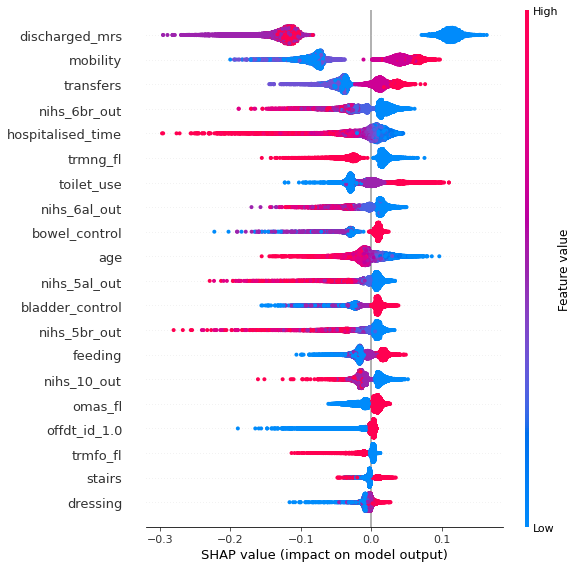

In [43]:
etB1_shap_values = shap.TreeExplainer(etB_ccCV.base_estimator._final_estimator).shap_values(B_X_train_overlap)

shap.summary_plot(etB1_shap_values[1], B_X_train_overlap)

## XGBClassifier

In [44]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.15, 7)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcB_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

In [45]:
#based
xgbc.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = xgbc.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc)

B_y_test_pred = xgbc.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc)

#tuned
xgbcB_rsCV = xgbcB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Paramxgbcers Best Score: ', xgbcB_rsCV.best_score_)
print('--> Best Paramxgbcers: \n', xgbcB_rsCV.best_params_)

B_y_train_pred = xgbcB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc_tuned)

B_y_test_pred = xgbcB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc_tuned)

#calibrated
xgbcB_cccv = CalibratedClassifierCV(base_estimator=xgbcB_rsCV.best_estimator_, cv=5)
xgbcB_ccCV = xgbcB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = xgbcB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc_cc)

B_y_test_pred = xgbcB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc_cc)

AUC of training sxgbc: 0.9603084074318282
AUC of testing sxgbc: 0.843569076033049
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.8607066272151004
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 7, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 10, 'xgbclassifier__colsample_bytree': 0.3}
AUC of training sxgbc: 0.8742411928718536
AUC of testing sxgbc: 0.854038667745642
AUC of training sxgbc: 0.8727667529246824
AUC of testing sxgbc: 0.8545060308750111


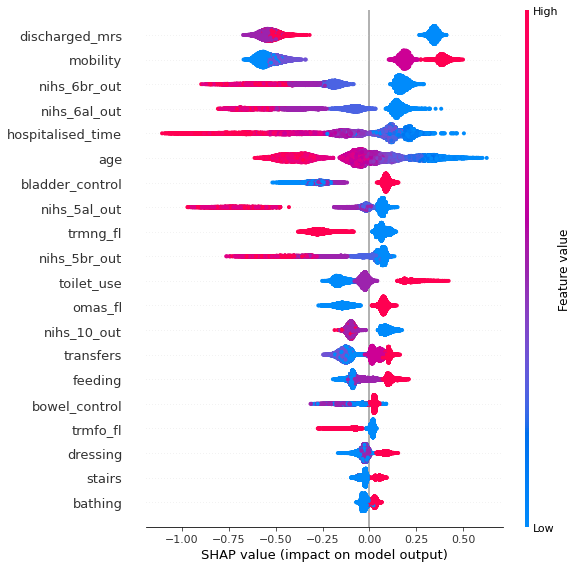

In [46]:
xgbcB1_shap_values = shap.TreeExplainer(xgbcB_ccCV.base_estimator._final_estimator).shap_values(B_X_train_overlap)

shap.summary_plot(xgbcB1_shap_values, B_X_train_overlap)

## LogisticRegression

In [47]:
# base lr
lr = LogisticRegression(random_state=19)

#tune lr
hyperparameters_lr = {"logisticregression__penalty": ("l1", "l2", "elasticnet", "none"),
                      "logisticregression__tol": (1e-4, 1e-3, 1e-2, 1e-1),
                      "logisticregression__C": (0.1, 1, 10),
                      "logisticregression__solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
                      "logisticregression__multi_class": ("auto", "ovr", "multinomial"),
                      "logisticregression__warm_start": (True, False),
                      "logisticregression__class_weight": ('balanced', {0: 1, 1: 7}, {0: 7, 1: 1})}

pipeline = make_pipeline(TomekLinks(), LogisticRegression(random_state=19))

lrB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_lr,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [48]:
lr.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = lr.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr)

B_y_test_pred = lr.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr)

#tuned
lrB_rsCV = lrB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Parameters Best Score: ', lrB_rsCV.best_score_)
print('--> Best Parameters: \n', lrB_rsCV.best_params_)

B_y_train_pred = lrB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr_tuned)

B_y_test_pred = lrB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr_tuned)

#calibrated
lrB_cccv = CalibratedClassifierCV(base_estimator=lrB_rsCV.best_estimator_, cv=5)
lrB_ccCV = lrB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = lrB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr_cc)

B_y_test_pred = lrB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr_cc)

AUC of training set: 0.8629864045840807
AUC of testing set: 0.8515561721708409
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8606659583484036
--> Best Parameters: 
 {'logisticregression__warm_start': True, 'logisticregression__tol': 0.001, 'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__multi_class': 'ovr', 'logisticregression__class_weight': {0: 1, 1: 7}, 'logisticregression__C': 0.1}
AUC of training set: 0.8626300383672931
AUC of testing set: 0.8518038737160529
AUC of training set: 0.8626859909460242
AUC of testing set: 0.8518475320267503


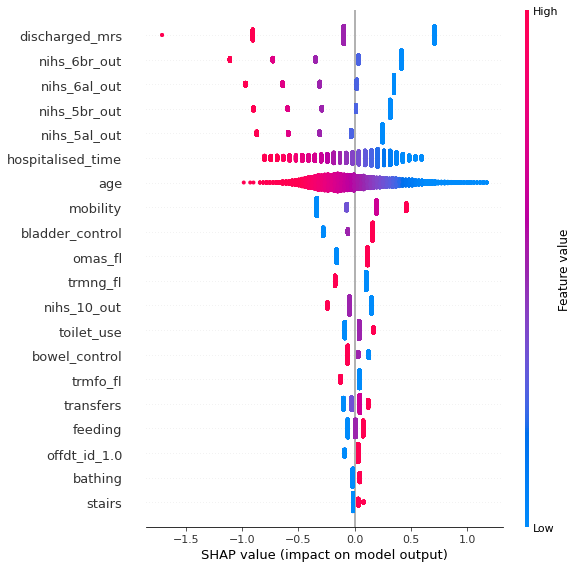

In [49]:
lrB1_explainer = shap.LinearExplainer(lrB_ccCV.base_estimator._final_estimator, B_X_train_overlap).shap_values(B_X_train_overlap)

shap.summary_plot(lrB1_explainer, B_X_train_overlap)

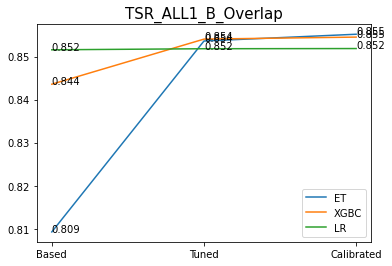

In [50]:
B_et_list = [B_test_auroc_et, B_test_auroc_et_tuned, B_test_auroc_et_cc]
B_xgbc_list = [B_test_auroc_xgbc, B_test_auroc_xgbc_tuned, B_test_auroc_xgbc_cc]
B_lr_list = [B_test_auroc_lr, B_test_auroc_lr_tuned, B_test_auroc_lr_cc]
x = "Based","Tuned","Calibrated"

plt.plot(x, B_et_list, label = "ET")
plt.plot(x, B_xgbc_list, label = "XGBC")
plt.plot(x, B_lr_list, label = "LR")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_et_list[i],3), (x[i], B_et_list[i]))
    plt.annotate(round(B_xgbc_list[i],3), (x[i], B_xgbc_list[i]))
    plt.annotate(round(B_lr_list[i],3), (x[i], B_lr_list[i]))
plt.title('TSR_ALL1_B_Overlap', fontsize=15)
#plt.savefig('INFO/TSR_ALL1/TSR_ALL1_B_Overlap.png')
plt.show()

# Machine Learning - TSR_ALL3

## Preprocess input data (GOOD when Discharge)

In [51]:
## discharged mRS = GOOD (tsr_all3_df.discharged_mrs == 1)
mrs_dis1 = tsr_all3_df[(tsr_all3_df.discharged_mrs == 1) | (tsr_all3_df.discharged_mrs == 0) | (tsr_all3_df.discharged_mrs == 2)]

In [52]:
## input dataset
tsr_3G_input = mrs_dis1.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1)
print(tsr_3G_input.shape)
tsr_3G_input = tsr_3G_input.astype("float64")
tsr_3G_input = np.array(tsr_3G_input.values)

(18940, 230)


In [53]:
## output dataset
tsr_3G_output = mrs_dis1.mrs_tx_3
print(tsr_3G_output.shape)
tsr_3G_output = tsr_3G_output.astype("float64")
tsr_3G_output = np.array(tsr_3G_output.values)

(18940,)


In [54]:
## train_test_split
G_X_train, G_X_test, G_y_train, G_y_test = train_test_split(tsr_3G_input, tsr_3G_output, test_size=0.3, random_state=19)
print("The shape of GOOD's X_train:", G_X_train.shape)
print("The shape of GOOD's y_train:", G_y_train.shape)
print("The shape of GOOD's X_test:", G_X_test.shape)
print("The shape of GOOD's y_test:", G_y_test.shape)

The shape of GOOD's X_train: (13258, 230)
The shape of GOOD's y_train: (13258,)
The shape of GOOD's X_test: (5682, 230)
The shape of GOOD's y_test: (5682,)


In [55]:
## scale G_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
G_X_train = pd.DataFrame(G_X_train)
G_X_train.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1).columns

scaler = MinMaxScaler()
G_X_train[continuous] = scaler.fit_transform(G_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=6)
G_X_train[ordinal_features] = encoder.fit_transform(G_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
nominal_train = ohe.fit_transform(G_X_train[nominal_features])
G_X_train = pd.concat([G_X_train, pd.DataFrame(nominal_train)], axis=1)
G_X_train = G_X_train.drop(nominal_features, axis=1)

G_x_train_columns = list(G_X_train.columns)
G_x_train_columns = G_x_train_columns[0:200]
get_feature_name = list(ohe.get_feature_names(nominal_features))
G_x_train_columns = G_x_train_columns+get_feature_name

G_X_train.columns = G_x_train_columns
G_X_train_overlap = G_X_train[T_I["G3"][0:15]]

#G_X_train_overlap = np.array(G_X_train_overlap.values)

In [56]:
## scale G_X_test
G_X_test = pd.DataFrame(G_X_test)
G_X_test.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1).columns

G_X_test[continuous] = scaler.transform(G_X_test[continuous])

G_X_test[ordinal_features] = encoder.transform(G_X_test[ordinal_features])

nominal_test = ohe.transform(G_X_test[nominal_features])
G_X_test = pd.concat([G_X_test, pd.DataFrame(nominal_test)], axis=1)
G_X_test = G_X_test.drop(nominal_features, axis=1)

G_X_test.columns = G_x_train_columns
G_X_test_overlap = G_X_test[T_I["G3"][0:15]]

#G_X_test_overlap = np.array(G_X_test_overlap.values)

## Extra trees

In [57]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 24}, {0: 24, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [58]:
#based
et.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = et.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et)

G_y_test_pred = et.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et)

#tuned
etG_rsCV = etG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Parameters Best Score: ', etG_rsCV.best_score_)
print('--> Best Parameters: \n', etG_rsCV.best_params_)

G_y_train_pred = etG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et_tuned)

G_y_test_pred = etG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et_tuned)

#calibrated
etG_cccv = CalibratedClassifierCV(base_estimator=etG_rsCV.best_estimator_, cv=5)
etG_ccCV = etG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = etG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et_cc)

G_y_test_pred = etG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et_cc)

AUC of training set: 0.9999910476962467
AUC of testing set: 0.6604854520387383
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7166416304366124
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.9, 'extratreesclassifier__max_depth': 25, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 1, 1: 24}, 'extratreesclassifier__bootstrap': True}
AUC of training set: 0.7895248279936911
AUC of testing set: 0.7381569349990091
AUC of training set: 0.7780339172454961
AUC of testing set: 0.7318575265303713


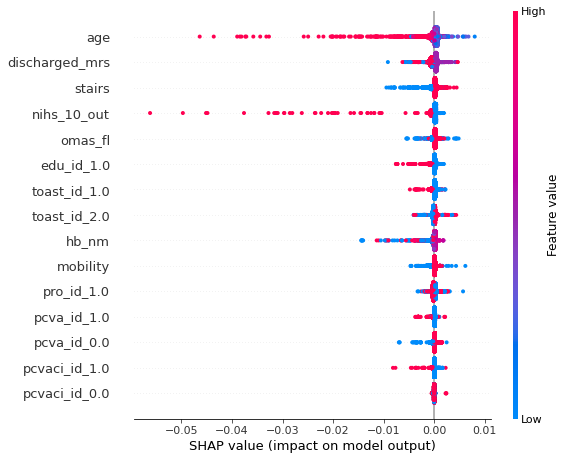

In [59]:
etG3_shap_values = shap.TreeExplainer(etG_ccCV.base_estimator._final_estimator).shap_values(G_X_train_overlap)

shap.summary_plot(etG3_shap_values[1], G_X_train_overlap)

## XGBClassifier

In [60]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.04, 24)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcG_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

In [61]:
#based
xgbc.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = xgbc.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc)

G_y_test_pred = xgbc.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc)

#tuned
xgbcG_rsCV = xgbcG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Paramxgbcers Best Score: ', xgbcG_rsCV.best_score_)
print('--> Best Paramxgbcers: \n', xgbcG_rsCV.best_params_)

G_y_train_pred = xgbcG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc_tuned)

G_y_test_pred = xgbcG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc_tuned)

#calibrated
xgbcG_cccv = CalibratedClassifierCV(base_estimator=xgbcG_rsCV.best_estimator_, cv=5)
xgbcG_ccCV = xgbcG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = xgbcG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc_cc)

G_y_test_pred = xgbcG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc_cc)

AUC of training sxgbc: 0.9707694704838107
AUC of testing sxgbc: 0.6490747572528996
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.724179876409979
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 0.04, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__n_estimators': 25, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.3}
AUC of training sxgbc: 0.7574975543933838
AUC of testing sxgbc: 0.7234584557784983
AUC of training sxgbc: 0.7533554492229029
AUC of testing sxgbc: 0.7250083269739145


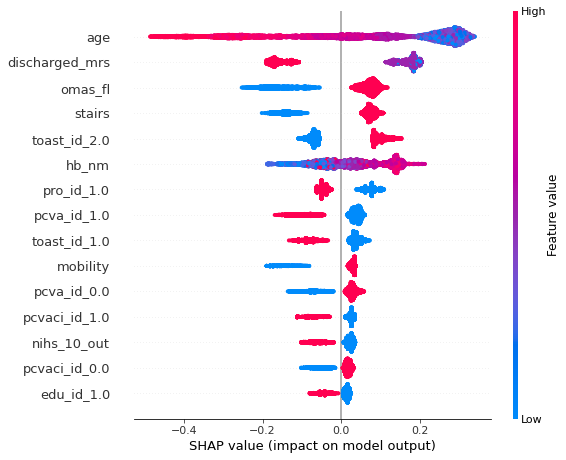

In [62]:
xgbcG3_shap_values = shap.TreeExplainer(xgbcG_ccCV.base_estimator._final_estimator).shap_values(G_X_train_overlap)

shap.summary_plot(xgbcG3_shap_values, G_X_train_overlap)

## LogisticRegression

In [63]:
# base lr
lr = LogisticRegression(random_state=19)

#tune lr
hyperparameters_lr = {"logisticregression__penalty": ("l1", "l2", "elasticnet", "none"),
                      "logisticregression__tol": (1e-4, 1e-3, 1e-2, 1e-1),
                      "logisticregression__C": (0.1, 1, 10),
                      "logisticregression__solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
                      "logisticregression__multi_class": ("auto", "ovr", "multinomial"),
                      "logisticregression__warm_start": (True, False),
                      "logisticregression__class_weight": ('balanced', {0: 1, 1: 24}, {0: 24, 1: 1})}

pipeline = make_pipeline(TomekLinks(), LogisticRegression(random_state=19))

lrG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_lr,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [64]:
lr.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = lr.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr)

G_y_test_pred = lr.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr)

#tuned
lrG_rsCV = lrG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Parameters Best Score: ', lrG_rsCV.best_score_)
print('--> Best Parameters: \n', lrG_rsCV.best_params_)

G_y_train_pred = lrG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr_tuned)

G_y_test_pred = lrG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr_tuned)

#calibrated
lrG_cccv = CalibratedClassifierCV(base_estimator=lrG_rsCV.best_estimator_, cv=5)
lrG_ccCV = lrG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = lrG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr_cc)

G_y_test_pred = lrG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr_cc)

AUC of training set: 0.7263823059861909
AUC of testing set: 0.7275570134201307
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.7212446909094604
--> Best Parameters: 
 {'logisticregression__warm_start': True, 'logisticregression__tol': 0.01, 'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__multi_class': 'ovr', 'logisticregression__class_weight': {0: 24, 1: 1}, 'logisticregression__C': 0.1}
AUC of training set: 0.7270427048564546
AUC of testing set: 0.7275477378036184
AUC of training set: 0.7269376447628209
AUC of testing set: 0.7279094868475975


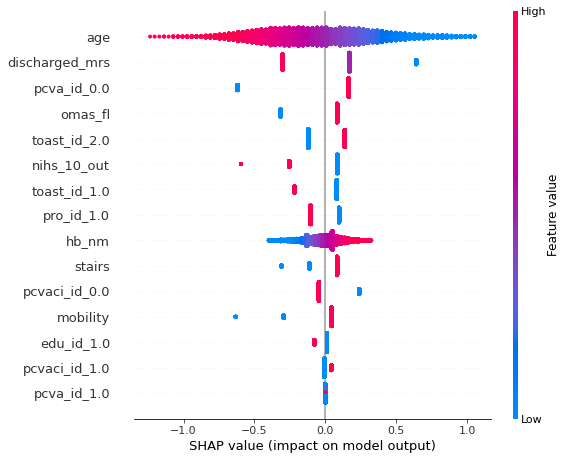

In [65]:
lrG3_explainer = shap.LinearExplainer(lrG_ccCV.base_estimator._final_estimator, G_X_train_overlap).shap_values(G_X_train_overlap)

shap.summary_plot(lrG3_explainer, G_X_train_overlap)

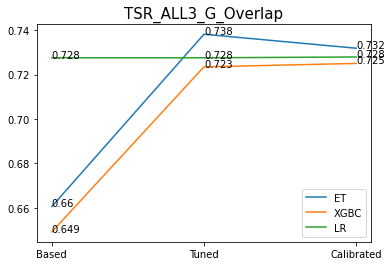

In [66]:
G_et_list = [G_test_auroc_et, G_test_auroc_et_tuned, G_test_auroc_et_cc]
G_xgbc_list = [G_test_auroc_xgbc, G_test_auroc_xgbc_tuned, G_test_auroc_xgbc_cc]
G_lr_list = [G_test_auroc_lr, G_test_auroc_lr_tuned, G_test_auroc_lr_cc]
x = "Based","Tuned","Calibrated"

plt.plot(x, G_et_list, label = "ET")
plt.plot(x, G_xgbc_list, label = "XGBC")
plt.plot(x, G_lr_list, label = "LR")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_et_list[i],3), (x[i], G_et_list[i]))
    plt.annotate(round(G_xgbc_list[i],3), (x[i], G_xgbc_list[i]))
    plt.annotate(round(G_lr_list[i],3), (x[i], G_lr_list[i]))
plt.title('TSR_ALL3_G_Overlap', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL3_G_Overlap.png')
plt.show()

# Machine Learning - TSR_ALL3

## Preprocess input data (BAD when Discharge)

In [67]:
# discharged mRS = BAD (tsr_all3_df.discharged_mrs == 0)
mrs_dis0 = tsr_all3_df[(tsr_all3_df.discharged_mrs != 1) & (tsr_all3_df.discharged_mrs != 0) & (tsr_all3_df.discharged_mrs != 2)]

In [68]:
## input dataset
tsr_3B_input = mrs_dis0.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1)
print(tsr_3B_input.shape)
tsr_3B_input = tsr_3B_input.astype("float64")
tsr_3B_input = np.array(tsr_3B_input.values)

(20941, 230)


In [69]:
## output dataset
tsr_3B_output = mrs_dis0.mrs_tx_3
print(tsr_3B_output.shape)
tsr_3B_output = tsr_3B_output.astype("float64")
tsr_3B_output = np.array(tsr_3B_output.values)

(20941,)


In [70]:
## train_test_split
B_X_train, B_X_test, B_y_train, B_y_test = train_test_split(tsr_3B_input, tsr_3B_output, test_size=0.3, random_state=19)
print("The shape of X_train:", B_X_train.shape)
print("The shape of y_train:", B_y_train.shape)
print("The shape of X_test:", B_X_test.shape)
print("The shape of y_test:", B_y_test.shape)

The shape of X_train: (14658, 230)
The shape of y_train: (14658,)
The shape of X_test: (6283, 230)
The shape of y_test: (6283,)


In [71]:
## scale B_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

B_X_train = pd.DataFrame(B_X_train)
B_X_train.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1).columns

scaler = MinMaxScaler()
B_X_train[continuous] = scaler.fit_transform(B_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=9)
B_X_train[ordinal_features] = encoder.fit_transform(B_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False)
nominal_train = ohe.fit_transform(B_X_train[nominal_features])
B_X_train = pd.concat([B_X_train, pd.DataFrame(nominal_train)], axis=1)
B_X_train = B_X_train.drop(nominal_features, axis=1)

B_x_train_columns = list(B_X_train.columns)
B_x_train_columns = B_x_train_columns[0:200]
get_feature_name = list(ohe.get_feature_names(nominal_features))
B_x_train_columns = B_x_train_columns+get_feature_name

B_X_train.columns = B_x_train_columns
B_X_train_overlap = B_X_train[T_I["B3"][0:21]]

#B_X_train_overlap = np.array(B_X_train_overlap.values)

In [72]:
## scale B_X_test
B_X_test = pd.DataFrame(B_X_test)
B_X_test.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_1", "mrs_tx_3"], axis=1).columns

B_X_test[continuous] = scaler.transform(B_X_test[continuous])

B_X_test[ordinal_features] = encoder.transform(B_X_test[ordinal_features])

nominal_test = ohe.transform(B_X_test[nominal_features])
B_X_test = pd.concat([B_X_test, pd.DataFrame(nominal_test)], axis=1)
B_X_test = B_X_test.drop(nominal_features, axis=1)

B_X_test.columns = B_x_train_columns
B_X_test_overlap = B_X_test[T_I["B3"][0:21]]

#B_X_test_overlap = np.array(B_X_test_overlap.values)

## Algorithms

## Extra trees

In [73]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 3}, {0: 3, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [74]:
#based
et.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = et.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et)

B_y_test_pred = et.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et)

#tuned
etB_rsCV = etB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Parameters Best Score: ', etB_rsCV.best_score_)
print('--> Best Parameters: \n', etB_rsCV.best_params_)

B_y_train_pred = etB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et_tuned)

B_y_test_pred = etB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et_tuned)

#calibrated
etB_cccv = CalibratedClassifierCV(base_estimator=etB_rsCV.best_estimator_, cv=5)
etB_ccCV = etB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = etB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et_cc)

B_y_test_pred = etB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et_cc)

AUC of training set: 0.9998270926937772
AUC of testing set: 0.8053756221721734
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.856668035424477
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 25, 'extratreesclassifier__max_samples': 0.8, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'entropy', 'extratreesclassifier__class_weight': {0: 1, 1: 3}, 'extratreesclassifier__bootstrap': True}
AUC of training set: 0.8969019056395098
AUC of testing set: 0.8580928070259122
AUC of training set: 0.8904402101480869
AUC of testing set: 0.8592388796332108


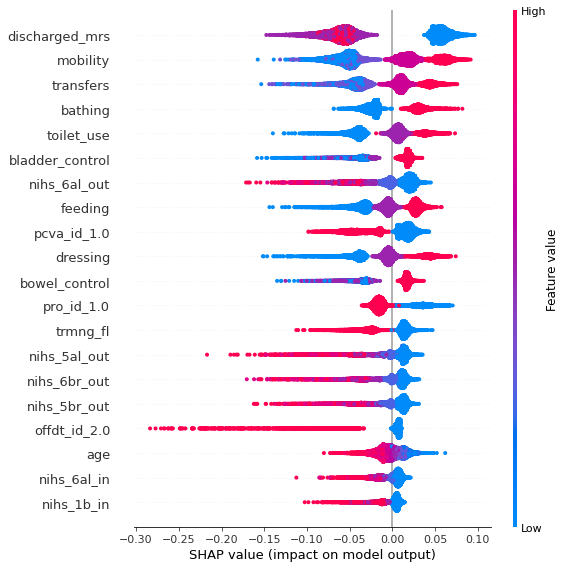

In [75]:
etB3_shap_values = shap.TreeExplainer(etB_ccCV.base_estimator._final_estimator).shap_values(B_X_train_overlap)

shap.summary_plot(etB3_shap_values[1], B_X_train_overlap)

## XGBClassifier

In [76]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.33, 3)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcB_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

In [77]:
#based
xgbc.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = xgbc.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc)

B_y_test_pred = xgbc.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc)

#tuned
xgbcB_rsCV = xgbcB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Paramxgbcers Best Score: ', xgbcB_rsCV.best_score_)
print('--> Best Paramxgbcers: \n', xgbcB_rsCV.best_params_)

B_y_train_pred = xgbcB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc_tuned)

B_y_test_pred = xgbcB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc_tuned)

#calibrated
xgbcB_cccv = CalibratedClassifierCV(base_estimator=xgbcB_rsCV.best_estimator_, cv=5)
xgbcB_ccCV = xgbcB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = xgbcB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc_cc)

B_y_test_pred = xgbcB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc_cc)

AUC of training sxgbc: 0.9416001965628811
AUC of testing sxgbc: 0.8463207434400741
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.8595331248179099
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.8, 'xgbclassifier__scale_pos_weight': 3, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 10, 'xgbclassifier__colsample_bytree': 0.3}
AUC of training sxgbc: 0.8654000111320351
AUC of testing sxgbc: 0.8623819948933177
AUC of training sxgbc: 0.8647372298548816
AUC of testing sxgbc: 0.8628798188351867


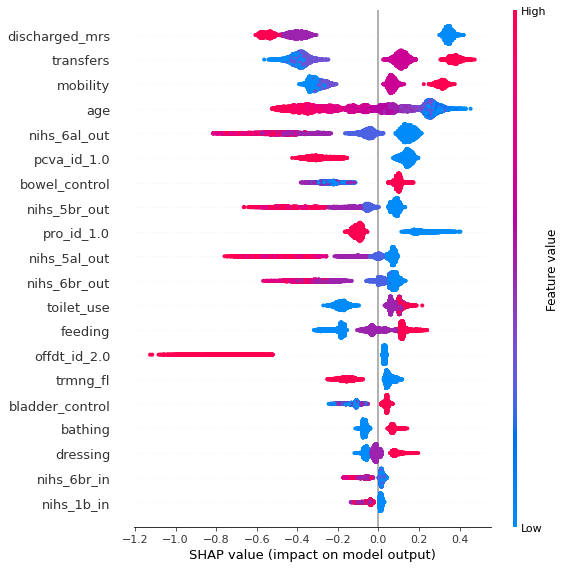

In [78]:
xgbcB3_shap_values = shap.TreeExplainer(xgbcB_ccCV.base_estimator._final_estimator).shap_values(B_X_train_overlap)

shap.summary_plot(xgbcB3_shap_values, B_X_train_overlap)

## LogisticRegression

In [79]:
# base lr
lr = LogisticRegression(random_state=19)

#tune lr
hyperparameters_lr = {"logisticregression__penalty": ("l1", "l2", "elasticnet", "none"),
                      "logisticregression__tol": (1e-4, 1e-3, 1e-2, 1e-1),
                      "logisticregression__C": (0.1, 1, 10),
                      "logisticregression__solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
                      "logisticregression__multi_class": ("auto", "ovr", "multinomial"),
                      "logisticregression__warm_start": (True, False),
                      "logisticregression__class_weight": ('balanced', {0: 1, 1: 3}, {0: 3, 1: 1})}

pipeline = make_pipeline(TomekLinks(), LogisticRegression(random_state=19))

lrB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_lr,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [80]:
lr.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = lr.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr)

B_y_test_pred = lr.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr)

#tuned
lrB_rsCV = lrB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Parameters Best Score: ', lrB_rsCV.best_score_)
print('--> Best Parameters: \n', lrB_rsCV.best_params_)

B_y_train_pred = lrB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr_tuned)

B_y_test_pred = lrB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr_tuned)

#calibrated
lrB_cccv = CalibratedClassifierCV(base_estimator=lrB_rsCV.best_estimator_, cv=5)
lrB_ccCV = lrB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = lrB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr_cc)

B_y_test_pred = lrB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr_cc)

AUC of training set: 0.8612464993356855
AUC of testing set: 0.8608821296577789
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8600092397980849
--> Best Parameters: 
 {'logisticregression__warm_start': True, 'logisticregression__tol': 0.001, 'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l1', 'logisticregression__multi_class': 'ovr', 'logisticregression__class_weight': {0: 1, 1: 3}, 'logisticregression__C': 0.1}
AUC of training set: 0.8610296823350062
AUC of testing set: 0.8608318444111253
AUC of training set: 0.8610275177726034
AUC of testing set: 0.860803972017266


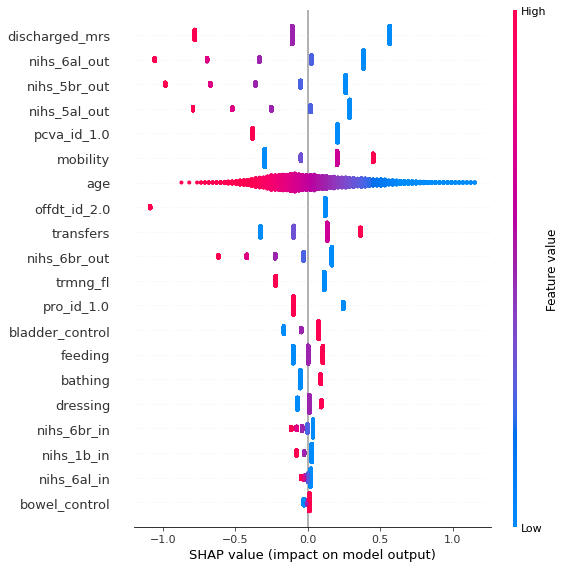

In [81]:
lrB3_explainer = shap.LinearExplainer(lrB_ccCV.base_estimator._final_estimator, B_X_train_overlap).shap_values(B_X_train_overlap)

shap.summary_plot(lrB3_explainer, B_X_train_overlap)

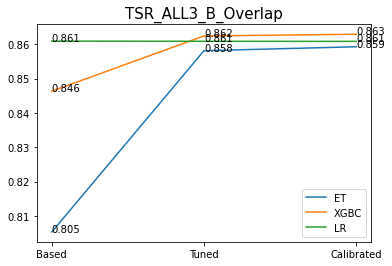

In [82]:
B_et_list = [B_test_auroc_et, B_test_auroc_et_tuned, B_test_auroc_et_cc]
B_xgbc_list = [B_test_auroc_xgbc, B_test_auroc_xgbc_tuned, B_test_auroc_xgbc_cc]
B_lr_list = [B_test_auroc_lr, B_test_auroc_lr_tuned, B_test_auroc_lr_cc]
x = "Based","Tuned","Calibrated"

plt.plot(x, B_et_list, label = "ET")
plt.plot(x, B_xgbc_list, label = "XGBC")
plt.plot(x, B_lr_list, label = "LR")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_et_list[i],3), (x[i], B_et_list[i]))
    plt.annotate(round(B_xgbc_list[i],3), (x[i], B_xgbc_list[i]))
    plt.annotate(round(B_lr_list[i],3), (x[i], B_lr_list[i]))
plt.title('TSR_ALL3_B_Overlap', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL3_B_Overlap.png')
plt.show()

# Machine Learning - TSR_ALL31

## Preprocess input data (GOOD when Discharge)

In [19]:
## discharged mRS = GOOD (tsr_all3_df.discharged_mrs == 1)
mrs_dis1 = tsr_all3_df[(tsr_all3_df.discharged_mrs == 1) | (tsr_all3_df.discharged_mrs == 0) | (tsr_all3_df.discharged_mrs == 2)]

In [20]:
## input dataset
tsr_3G_input = mrs_dis1.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1)
print(tsr_3G_input.shape)
tsr_3G_input = tsr_3G_input.astype("float64")
tsr_3G_input = np.array(tsr_3G_input.values)

(18940, 231)


In [21]:
## output dataset
tsr_3G_output = mrs_dis1.mrs_tx_3
print(tsr_3G_output.shape)
tsr_3G_output = tsr_3G_output.astype("float64")
tsr_3G_output = np.array(tsr_3G_output.values)

(18940,)


In [22]:
## train_test_split
G_X_train, G_X_test, G_y_train, G_y_test = train_test_split(tsr_3G_input, tsr_3G_output, test_size=0.3, random_state=19)
print("The shape of GOOD's X_train:", G_X_train.shape)
print("The shape of GOOD's y_train:", G_y_train.shape)
print("The shape of GOOD's X_test:", G_X_test.shape)
print("The shape of GOOD's y_test:", G_y_test.shape)

The shape of GOOD's X_train: (13258, 231)
The shape of GOOD's y_train: (13258,)
The shape of GOOD's X_test: (5682, 231)
The shape of GOOD's y_test: (5682,)


In [23]:
## scale G_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
G_X_train = pd.DataFrame(G_X_train)
G_X_train.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

scaler = MinMaxScaler()
G_X_train[continuous] = scaler.fit_transform(G_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=6)
G_X_train[ordinal_features] = encoder.fit_transform(G_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
nominal_train = ohe.fit_transform(G_X_train[nominal_features])
G_X_train = pd.concat([G_X_train, pd.DataFrame(nominal_train)], axis=1)
G_X_train = G_X_train.drop(nominal_features, axis=1)

G_x_train_columns = list(G_X_train.columns)
G_x_train_columns = G_x_train_columns[0:201]
get_feature_name = list(ohe.get_feature_names(nominal_features))
G_x_train_columns = G_x_train_columns+get_feature_name

G_X_train.columns = G_x_train_columns
G_X_train_overlap = G_X_train[T_I["G31"][0:6]]

#G_X_train_overlap = np.array(G_X_train_overlap.values)

In [24]:
## scale G_X_test
G_X_test = pd.DataFrame(G_X_test)
G_X_test.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

G_X_test[continuous] = scaler.transform(G_X_test[continuous])

G_X_test[ordinal_features] = encoder.transform(G_X_test[ordinal_features])

nominal_test = ohe.transform(G_X_test[nominal_features])
G_X_test = pd.concat([G_X_test, pd.DataFrame(nominal_test)], axis=1)
G_X_test = G_X_test.drop(nominal_features, axis=1)

G_X_test.columns = G_x_train_columns
G_X_test_overlap = G_X_test[T_I["G31"][0:6]]
                            
#G_X_test_overlap = np.array(G_X_test_overlap.values)

## Extra trees

In [25]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 24}, {0: 24, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [26]:
#based
et.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = et.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et)

G_y_test_pred = et.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et)

#tuned
etG_rsCV = etG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Parameters Best Score: ', etG_rsCV.best_score_)
print('--> Best Parameters: \n', etG_rsCV.best_params_)

G_y_train_pred = etG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et_tuned)

G_y_test_pred = etG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et_tuned)

#calibrated
etG_cccv = CalibratedClassifierCV(base_estimator=etG_rsCV.best_estimator_, cv=5)
etG_ccCV = etG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = etG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_et_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_et_cc)

G_y_test_pred = etG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_et_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_et_cc)

AUC of training set: 1.0
AUC of testing set: 0.8004578781605608
Fitting 5 folds for each of 10 candidates, totalling 50 fits
--> Tuned Parameters Best Score:  0.8292522137564958
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.1, 'extratreesclassifier__max_depth': 100, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 24, 1: 1}, 'extratreesclassifier__bootstrap': False}
AUC of training set: 0.9993335342792589
AUC of testing set: 0.8369051483887833
AUC of training set: 0.9989960102319654
AUC of testing set: 0.8391970689051821


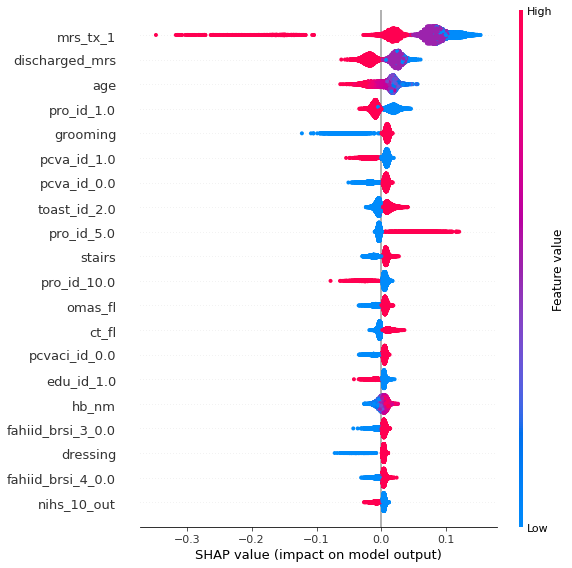

In [27]:
etG31_shap_values = shap.TreeExplainer(etG_ccCV.base_estimator._final_estimator).shap_values(G_X_train_overlap)

shap.summary_plot(etG31_shap_values[1], G_X_train_overlap)

## XGBClassifier

In [92]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.04, 24)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcG_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

In [93]:
#based
xgbc.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = xgbc.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc)

G_y_test_pred = xgbc.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc)

#tuned
xgbcG_rsCV = xgbcG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Paramxgbcers Best Score: ', xgbcG_rsCV.best_score_)
print('--> Best Paramxgbcers: \n', xgbcG_rsCV.best_params_)

G_y_train_pred = xgbcG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc_tuned)

G_y_test_pred = xgbcG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc_tuned)

#calibrated
xgbcG_cccv = CalibratedClassifierCV(base_estimator=xgbcG_rsCV.best_estimator_, cv=5)
xgbcG_ccCV = xgbcG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = xgbcG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of training sxgbc:', G_train_auroc_xgbc_cc)

G_y_test_pred = xgbcG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of testing sxgbc:', G_test_auroc_xgbc_cc)

AUC of training sxgbc: 0.9294824073913771
AUC of testing sxgbc: 0.7966481294876064
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.8332065101434193
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 24, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.8}
AUC of training sxgbc: 0.8388901244547788
AUC of testing sxgbc: 0.8482108600604601
AUC of training sxgbc: 0.8378069696866117
AUC of testing sxgbc: 0.847907294429149


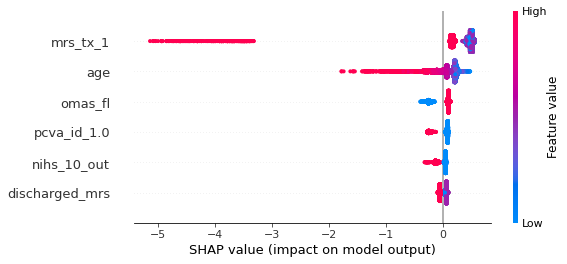

In [94]:
xgbcG31_shap_values = shap.TreeExplainer(xgbcG_ccCV.base_estimator._final_estimator).shap_values(G_X_train_overlap)

shap.summary_plot(xgbcG31_shap_values, G_X_train_overlap)

## LogisticRegression

In [95]:
# base lr
lr = LogisticRegression(random_state=19)

#tune lr
hyperparameters_lr = {"logisticregression__penalty": ("l1", "l2", "elasticnet", "none"),
                      "logisticregression__tol": (1e-4, 1e-3, 1e-2, 1e-1),
                      "logisticregression__C": (0.1, 1, 10),
                      "logisticregression__solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
                      "logisticregression__multi_class": ("auto", "ovr", "multinomial"),
                      "logisticregression__warm_start": (True, False),
                      "logisticregression__class_weight": ('balanced', {0: 1, 1: 24}, {0: 24, 1: 1})}

pipeline = make_pipeline(TomekLinks(), LogisticRegression(random_state=19))

lrG_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_lr,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [96]:
lr.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = lr.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr)

G_y_test_pred = lr.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr)

#tuned
lrG_rsCV = lrG_rscv.fit(G_X_train_overlap, G_y_train)
print('--> Tuned Parameters Best Score: ', lrG_rsCV.best_score_)
print('--> Best Parameters: \n', lrG_rsCV.best_params_)

G_y_train_pred = lrG_rsCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr_tuned)

G_y_test_pred = lrG_rsCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr_tuned)

#calibrated
lrG_cccv = CalibratedClassifierCV(base_estimator=lrG_rsCV.best_estimator_, cv=5)
lrG_ccCV = lrG_cccv.fit(G_X_train_overlap, G_y_train)

G_y_train_pred = lrG_ccCV.predict_proba(G_X_train_overlap)
fpr, tpr, thresholds = roc_curve(G_y_train, G_y_train_pred[:, 1])
G_train_auroc_lr_cc = auc(fpr, tpr)
print('AUC of training set:', G_train_auroc_lr_cc)

G_y_test_pred = lrG_ccCV.predict_proba(G_X_test_overlap)
fpr, tpr, thresholds = roc_curve(G_y_test, G_y_test_pred[:, 1])
G_test_auroc_lr_cc = auc(fpr, tpr)
print('AUC of testing set:', G_test_auroc_lr_cc)

AUC of training set: 0.8255521536801292
AUC of testing set: 0.8318305429186992
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.8285247756378329
--> Best Parameters: 
 {'logisticregression__warm_start': False, 'logisticregression__tol': 0.0001, 'logisticregression__solver': 'newton-cg', 'logisticregression__penalty': 'l2', 'logisticregression__multi_class': 'ovr', 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 10}
AUC of training set: 0.8302308791739376
AUC of testing set: 0.8361150345095096
AUC of training set: 0.8301212319494552
AUC of testing set: 0.8359784299754197


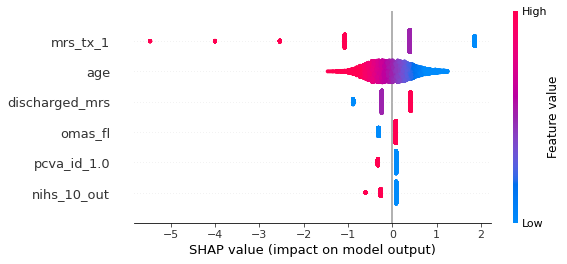

In [97]:
lrG31_explainer = shap.LinearExplainer(lrG_ccCV.base_estimator._final_estimator, G_X_train_overlap).shap_values(G_X_train_overlap)

shap.summary_plot(lrG31_explainer, G_X_train_overlap)

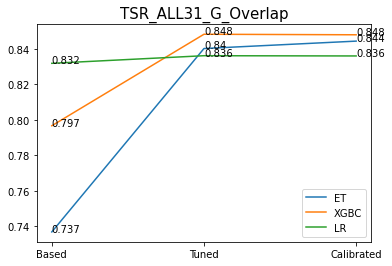

In [98]:
G_et_list = [G_test_auroc_et, G_test_auroc_et_tuned, G_test_auroc_et_cc]
G_xgbc_list = [G_test_auroc_xgbc, G_test_auroc_xgbc_tuned, G_test_auroc_xgbc_cc]
G_lr_list = [G_test_auroc_lr, G_test_auroc_lr_tuned, G_test_auroc_lr_cc]
x = "Based","Tuned","Calibrated"

plt.plot(x, G_et_list, label = "ET")
plt.plot(x, G_xgbc_list, label = "XGBC")
plt.plot(x, G_lr_list, label = "LR")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(G_et_list[i],3), (x[i], G_et_list[i]))
    plt.annotate(round(G_xgbc_list[i],3), (x[i], G_xgbc_list[i]))
    plt.annotate(round(G_lr_list[i],3), (x[i], G_lr_list[i]))
plt.title('TSR_ALL31_G_Overlap', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL31_G_Overlap.png')
plt.show()

# Machine Learning - TSR_ALL31

## Preprocess input data (BAD when Discharge)

In [99]:
# discharged mRS = BAD (tsr_all3_df.discharged_mrs == 0)
mrs_dis0 = tsr_all3_df[(tsr_all3_df.discharged_mrs != 1) & (tsr_all3_df.discharged_mrs != 0) & (tsr_all3_df.discharged_mrs != 2)]

In [100]:
## input dataset
tsr_3B_input = mrs_dis0.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1)
print(tsr_3B_input.shape)
tsr_3B_input = tsr_3B_input.astype("float64")
tsr_3B_input = np.array(tsr_3B_input.values)

(20941, 231)


In [101]:
## output dataset
tsr_3B_output = mrs_dis0.mrs_tx_3
print(tsr_3B_output.shape)
tsr_3B_output = tsr_3B_output.astype("float64")
tsr_3B_output = np.array(tsr_3B_output.values)

(20941,)


In [102]:
## train_test_split
B_X_train, B_X_test, B_y_train, B_y_test = train_test_split(tsr_3B_input, tsr_3B_output, test_size=0.3, random_state=19)
print("The shape of X_train:", B_X_train.shape)
print("The shape of y_train:", B_y_train.shape)
print("The shape of X_test:", B_X_test.shape)
print("The shape of y_test:", B_y_test.shape)

The shape of X_train: (14658, 231)
The shape of y_train: (14658,)
The shape of X_test: (6283, 231)
The shape of y_test: (6283,)


In [103]:
## scale B_X_train
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

B_X_train = pd.DataFrame(B_X_train)
B_X_train.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

scaler = MinMaxScaler()
B_X_train[continuous] = scaler.fit_transform(B_X_train[continuous])

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=9)
B_X_train[ordinal_features] = encoder.fit_transform(B_X_train[ordinal_features])

ohe = OneHotEncoder(sparse=False)
nominal_train = ohe.fit_transform(B_X_train[nominal_features])
B_X_train = pd.concat([B_X_train, pd.DataFrame(nominal_train)], axis=1)
B_X_train = B_X_train.drop(nominal_features, axis=1)

B_x_train_columns = list(B_X_train.columns)
B_x_train_columns = B_x_train_columns[0:201]
get_feature_name = list(ohe.get_feature_names(nominal_features))
B_x_train_columns = B_x_train_columns+get_feature_name

B_X_train.columns = B_x_train_columns
B_X_train_overlap = B_X_train[T_I["B31"][0:16]]

#B_X_train_overlap = np.array(B_X_train_overlap.values)

In [104]:
## scale B_X_test
B_X_test = pd.DataFrame(B_X_test)
B_X_test.columns = tsr_all3_df.drop(["icase_id", "idcase_id", "mrs_tx_3"], axis=1).columns

B_X_test[continuous] = scaler.transform(B_X_test[continuous])

B_X_test[ordinal_features] = encoder.transform(B_X_test[ordinal_features])

nominal_test = ohe.transform(B_X_test[nominal_features])
B_X_test = pd.concat([B_X_test, pd.DataFrame(nominal_test)], axis=1)
B_X_test = B_X_test.drop(nominal_features, axis=1)

B_X_test.columns = B_x_train_columns
B_X_test_overlap = B_X_test[T_I["B31"][0:16]]

#B_X_test_overlap = np.array(B_X_test_overlap.values)

## Algorithms

## Extra trees

In [105]:
# base et
et = ExtraTreesClassifier(random_state=19)

#tune et
hyperparameters_et = {"extratreesclassifier__n_estimators": (25, 100),
                      "extratreesclassifier__criterion": ("gini", "entropy"),
                      "extratreesclassifier__max_depth": (25, 100),
                      "extratreesclassifier__min_samples_split": (25, 100),
                      "extratreesclassifier__max_features": (0.1, 0.9),
                      "extratreesclassifier__bootstrap": (True, False),
                      "extratreesclassifier__class_weight": ('balanced', {0: 1, 1: 3}, {0: 3, 1: 1}),
                      "extratreesclassifier__max_samples": (0.3, 0.8)}

pipeline = make_pipeline(TomekLinks(), ExtraTreesClassifier(random_state=19))

etB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_et,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [106]:
#based
et.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = et.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et)

B_y_test_pred = et.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et)

#tuned
etB_rsCV = etB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Parameters Best Score: ', etB_rsCV.best_score_)
print('--> Best Parameters: \n', etB_rsCV.best_params_)

B_y_train_pred = etB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et_tuned)

B_y_test_pred = etB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et_tuned)

#calibrated
etB_cccv = CalibratedClassifierCV(base_estimator=etB_rsCV.best_estimator_, cv=5)
etB_ccCV = etB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = etB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_et_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_et_cc)

B_y_test_pred = etB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_et_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_et_cc)

AUC of training set: 0.9937180276095089
AUC of testing set: 0.8649365572593792
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.9275179208829185
--> Best Parameters: 
 {'extratreesclassifier__n_estimators': 100, 'extratreesclassifier__min_samples_split': 100, 'extratreesclassifier__max_samples': 0.3, 'extratreesclassifier__max_features': 0.9, 'extratreesclassifier__max_depth': 25, 'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__class_weight': {0: 1, 1: 3}, 'extratreesclassifier__bootstrap': True}
AUC of training set: 0.9355449491997819
AUC of testing set: 0.9216527841073334
AUC of training set: 0.9345440194686927
AUC of testing set: 0.9217842441092989


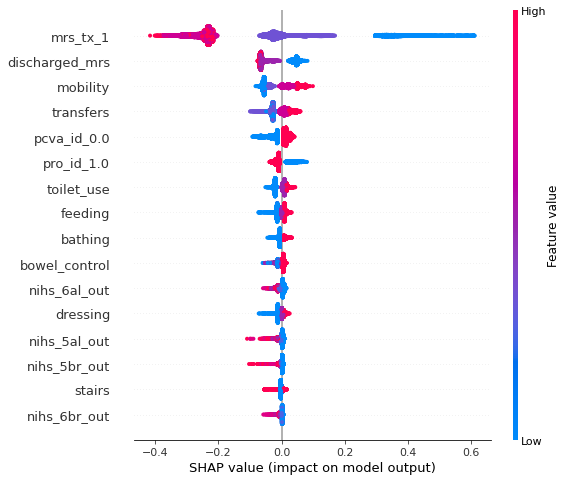

In [107]:
etB31_shap_values = shap.TreeExplainer(etB_ccCV.base_estimator._final_estimator).shap_values(B_X_train_overlap)

shap.summary_plot(etB31_shap_values[1], B_X_train_overlap)

## XGBClassifier

In [108]:
# base xgbc
xgbc = XGBClassifier(booster = "gbtree", random_state=19, use_label_encoder=False, eval_metric = "auc", tree_method = "hist", n_jobs=-1)

# tune xgbc
hyperparameters_xgbc = {"xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__learning_rate": (0.01, 0.1),
                        "xgbclassifier__max_depth": (25, 50),
                        "xgbclassifier__subsample": (0.3, 0.8),
                        "xgbclassifier__colsample_bytree": (0.3, 0.8),
                        "xgbclassifier__reg_lambda": (0.1, 10),
                        "xgbclassifier__reg_alpha": (0.1, 10),
                        "xgbclassifier__gamma": (0.1, 10),
                        "xgbclassifier__n_estimators": (25, 100),
                        "xgbclassifier__scale_pos_weight": (0.33, 3)}

pipeline = make_pipeline(TomekLinks(), XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="auc", tree_method = "hist"))

xgbcB_rscv = RandomizedSearchCV(estimator=pipeline,                       
                                param_distributions=hyperparameters_xgbc,                      
                                n_jobs=-1,                      
                                scoring="roc_auc",                     
                                verbose=5,                      
                                cv=5,                        
                                n_iter=50,
                                random_state = 19)

In [109]:
#based
xgbc.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = xgbc.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc)

B_y_test_pred = xgbc.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc)

#tuned
xgbcB_rsCV = xgbcB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Paramxgbcers Best Score: ', xgbcB_rsCV.best_score_)
print('--> Best Paramxgbcers: \n', xgbcB_rsCV.best_params_)

B_y_train_pred = xgbcB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc_tuned)

B_y_test_pred = xgbcB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc_tuned = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc_tuned)

#calibrated
xgbcB_cccv = CalibratedClassifierCV(base_estimator=xgbcB_rsCV.best_estimator_, cv=5)
xgbcB_ccCV = xgbcB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = xgbcB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of training sxgbc:', B_train_auroc_xgbc_cc)

B_y_test_pred = xgbcB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_xgbc_cc = auc(fpr, tpr)
print('AUC of testing sxgbc:', B_test_auroc_xgbc_cc)

AUC of training sxgbc: 0.9614174353440057
AUC of testing sxgbc: 0.9182644205156911
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Paramxgbcers Best Score:  0.9286020579719538
--> Best Paramxgbcers: 
 {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 3, 'xgbclassifier__reg_lambda': 10, 'xgbclassifier__reg_alpha': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 25, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__colsample_bytree': 0.8}
AUC of training sxgbc: 0.9372186068876375
AUC of testing sxgbc: 0.9230918760304884
AUC of training sxgbc: 0.9362125620894418
AUC of testing sxgbc: 0.9228584806499497


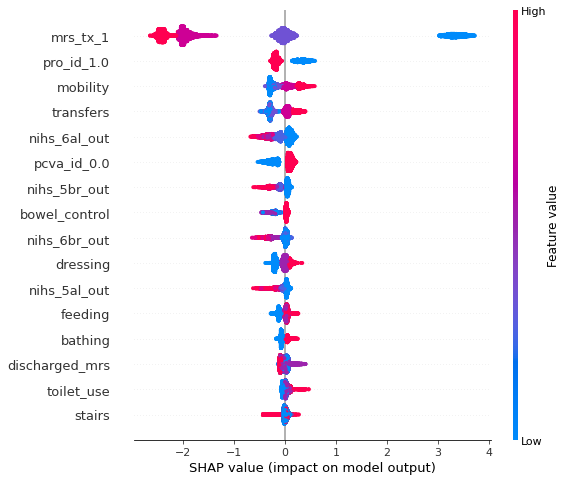

In [110]:
xgbcB31_shap_values = shap.TreeExplainer(xgbcB_ccCV.base_estimator._final_estimator).shap_values(B_X_train_overlap)

shap.summary_plot(xgbcB31_shap_values, B_X_train_overlap)

## LogisticRegression

In [111]:
# base lr
lr = LogisticRegression(random_state=19)

#tune lr
hyperparameters_lr = {"logisticregression__penalty": ("l1", "l2", "elasticnet", "none"),
                      "logisticregression__tol": (1e-4, 1e-3, 1e-2, 1e-1),
                      "logisticregression__C": (0.1, 1, 10),
                      "logisticregression__solver": ("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
                      "logisticregression__multi_class": ("auto", "ovr", "multinomial"),
                      "logisticregression__warm_start": (True, False),
                      "logisticregression__class_weight": ('balanced', {0: 1, 1: 3}, {0: 3, 1: 1})}

pipeline = make_pipeline(TomekLinks(), LogisticRegression(random_state=19))

lrB_rscv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions=hyperparameters_lr,
                              n_jobs=-1,
                              scoring='roc_auc',
                              verbose=5,                        
                              cv=5,
                              n_iter = 50,
                              random_state = 19)

In [112]:
lr.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = lr.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr)

B_y_test_pred = lr.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr)

#tuned
lrB_rsCV = lrB_rscv.fit(B_X_train_overlap, B_y_train)
print('--> Tuned Parameters Best Score: ', lrB_rsCV.best_score_)
print('--> Best Parameters: \n', lrB_rsCV.best_params_)

B_y_train_pred = lrB_rsCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr_tuned)

B_y_test_pred = lrB_rsCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr_tuned = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr_tuned)

#calibrated
lrB_cccv = CalibratedClassifierCV(base_estimator=lrB_rsCV.best_estimator_, cv=5)
lrB_ccCV = lrB_cccv.fit(B_X_train_overlap, B_y_train)

B_y_train_pred = lrB_ccCV.predict_proba(B_X_train_overlap)
fpr, tpr, thresholds = roc_curve(B_y_train, B_y_train_pred[:, 1])
B_train_auroc_lr_cc = auc(fpr, tpr)
print('AUC of training set:', B_train_auroc_lr_cc)

B_y_test_pred = lrB_ccCV.predict_proba(B_X_test_overlap)
fpr, tpr, thresholds = roc_curve(B_y_test, B_y_test_pred[:, 1])
B_test_auroc_lr_cc = auc(fpr, tpr)
print('AUC of testing set:', B_test_auroc_lr_cc)

AUC of training set: 0.9296183773409484
AUC of testing set: 0.920804831176623
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--> Tuned Parameters Best Score:  0.9289297341842714
--> Best Parameters: 
 {'logisticregression__warm_start': True, 'logisticregression__tol': 0.001, 'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__multi_class': 'ovr', 'logisticregression__class_weight': {0: 1, 1: 3}, 'logisticregression__C': 0.1}
AUC of training set: 0.929610260231938
AUC of testing set: 0.9210184716388334
AUC of training set: 0.9296287105495618
AUC of testing set: 0.9210816873774835


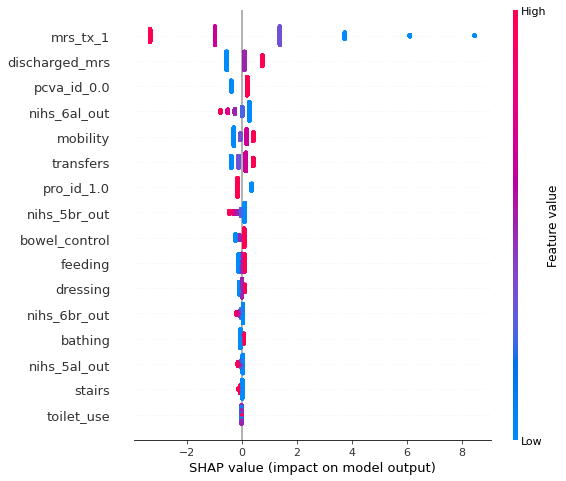

In [113]:
lrB31_explainer = shap.LinearExplainer(lrB_ccCV.base_estimator._final_estimator, B_X_train_overlap).shap_values(B_X_train_overlap)

shap.summary_plot(lrB31_explainer, B_X_train_overlap)

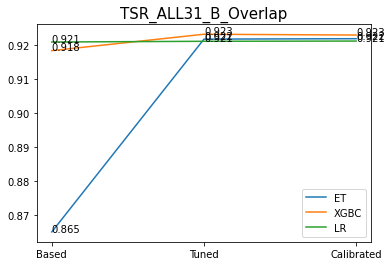

In [114]:
B_et_list = [B_test_auroc_et, B_test_auroc_et_tuned, B_test_auroc_et_cc]
B_xgbc_list = [B_test_auroc_xgbc, B_test_auroc_xgbc_tuned, B_test_auroc_xgbc_cc]
B_lr_list = [B_test_auroc_lr, B_test_auroc_lr_tuned, B_test_auroc_lr_cc]
x = "Based","Tuned","Calibrated"

plt.plot(x, B_et_list, label = "ET")
plt.plot(x, B_xgbc_list, label = "XGBC")
plt.plot(x, B_lr_list, label = "LR")
plt.legend()
for i in range(len(x)):
    plt.annotate(round(B_et_list[i],3), (x[i], B_et_list[i]))
    plt.annotate(round(B_xgbc_list[i],3), (x[i], B_xgbc_list[i]))
    plt.annotate(round(B_lr_list[i],3), (x[i], B_lr_list[i]))
plt.title('TSR_ALL31_B_Overlap', fontsize=15)
#plt.savefig('INFO/TSR_ALL3/TSR_ALL31_B_Overlap.png')
plt.show()